In [1]:
%pip --quiet install git+https://github.com/mfinzi/equivariant-MLP.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 5.1 MB/s eta 0:00:00


In [2]:
from functools import partial

import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
import emlp
solve_ivp = scipy.integrate.solve_ivp

In [3]:
def random_config(m1=1.0, m2=1.0, orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
    state = np.zeros((2,5))
    state[0,0] = m1
    state[1,0] = m2
    pos = np.random.rand(2) * (max_radius-min_radius) + min_radius
    r = np.sqrt( np.sum((pos**2)) )

    # velocity that yields a circular orbit
    vel = np.flipud(pos) / (2 * r**1.5)
    vel[0] *= -1
    vel *= 1 + orbit_noise*np.random.randn()

    # make the circular orbits SLIGHTLY elliptical
    state[:,1:3] = pos
    state[:,3:5] = vel
    state[1,1:] *= -1
    return state

In [4]:
##### ENERGY #####
def potential_energy(state):
    '''U=sum_i,j>i G m_i m_j / r_ij'''
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
    tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

def kinetic_energy(state):
    '''T=sum_i .5*m*v^2'''
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)


##### DYNAMICS #####
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs

In [5]:
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)

def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings

In [6]:
a, b= get_orbit(random_config(), t_points=100)

In [7]:
part1 = a.transpose(2,0,1)[:,0, 1:]

In [8]:
part2 = a.transpose(2,0,1)[:,1, 1:]

In [9]:
np.concatenate([part1,part2], axis=1 ).flatten().shape

(800,)

In [10]:
from emlp.groups import Sp
def get_equivariant_dataset(timesteps=50, train_size=2000, test_size=100, nbodies=2, orbit_noise=5e-2,
                  min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):

    data = {'meta': locals()}

    train_xs = []
    train_ys = []
    #N = timesteps*trials
    for i in range(train_size):
        #state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings = get_orbit(random_config(m1=1.3, m2=0.8), t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1)
        g = np.asarray(Sp(2).sample())
        part1 = np.einsum('ij , bj -> bi', g, batch[:,0,1:])
        part2 = np.einsum('ij , bj -> bi', g, batch[:,1,1:])
        train_xs.append( np.concatenate([part1,part2], axis=1 ).flatten() )
        train_ys.append( 0)


        orbit, settings = get_orbit(random_config(m1=1.1, m2=0.9), t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1)
        g = np.asarray(Sp(2).sample())
        part1 = np.einsum('ij , bj -> bi', g, batch[:,0,1:])
        part2 = np.einsum('ij , bj -> bi', g, batch[:,1,1:])
        train_xs.append( np.concatenate([part1,part2], axis=1 ).flatten() )
        train_ys.append( 1)


    test_xs = []
    test_ys = []
    #N = timesteps*trials
    for i in range(train_size):
        #state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings = get_orbit(random_config(m1=1.3, m2=0.8), t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1)
        g = np.asarray(Sp(2).sample())
        part1 = np.einsum('ij , bj -> bi', g, batch[:,0,1:])
        part2 = np.einsum('ij , bj -> bi', g, batch[:,1,1:])
        test_xs.append( np.concatenate([part1,part2], axis=1 ).flatten() )
        test_ys.append( 0)


        orbit, settings = get_orbit(random_config(m1=1.1, m2=0.9), t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1)
        g = np.asarray(Sp(2).sample())
        part1 = np.einsum('ij , bj -> bi', g, batch[:,0,1:])
        part2 = np.einsum('ij , bj -> bi', g, batch[:,1,1:])
        test_xs.append( np.concatenate([part1,part2], axis=1 ).flatten() )
        test_ys.append( 1)

    data['train_x'] = np.stack(train_xs)
    data['train_y'] = np.array(train_ys)
    data['test_x'] = np.stack(test_xs)
    data['test_y'] = np.array(test_ys)
    return data

In [11]:
data = get_equivariant_dataset()

In [12]:
data['train_x'].shape

(4000, 400)

# Constructing Dataset

In [14]:
import jax.numpy as jnp
from emlp.reps import Scalar,Vector,T
from emlp.utils import export,Named
from emlp.groups import Sp
import itertools
from jax import vmap,jit, grad
from objax import Module

In [15]:
class GroupAugmentation(Module):
    def __init__(self,network,rep_in,rep_out,group):
        super().__init__()
        self.rep_in=rep_in
        self.rep_out=rep_out
        self.G=group
        self.rho_in = jit(vmap(self.rep_in.rho))
        self.rho_out = jit(vmap(self.rep_out.rho))
        self.model = network
    def __call__(self,x,training=True):
        if training:
            gs = self.G.samples(x.shape[0])
            rhout_inv = jnp.linalg.inv(self.rho_out(gs))
            return (rhout_inv@self.model((self.rho_in(gs)@x[...,None])[...,0],training)[...,None])[...,0]
        else:
            return self.model(x,False)

class TwoBody(object):
    def __init__(self, x, y):
        super().__init__()
        self.dim = 4
        self.X = x
        self.Y = y
        self.rep_in = 100*Vector
        self.rep_out = Scalar
        self.symmetry = Sp(2)
        # One has to be careful computing mean and std in a way so that standardizing
        # does not violate equivariance
        self.stats = self.X.mean(axis=0),self.X.std(axis=0),self.Y.mean(axis=0),self.Y.std(axis=0) #Xmean,Xstd,Ymean,Ystd

    def __getitem__(self,i):
        return (self.X[i],self.Y[i])
    def __len__(self):
        return self.X.shape[0]
    def default_aug(self, model):
        return GroupAugmentation(model,self.rep_in,self.rep_out,self.symmetry)




# model

In [ ]:
import jax
import jax.numpy as jnp
import objax.nn as nn
import objax.functional as F
import numpy as np
from emlp.reps import T,Rep,Scalar
from emlp.reps import bilinear_weights
from emlp.reps.product_sum_reps import SumRep
import collections
from emlp.utils import Named,export
import scipy as sp
import scipy.special
import random
import logging
from objax.variable import TrainVar, StateVar
from objax.nn.init import kaiming_normal, xavier_normal
from objax.module import Module
import objax
from objax.nn.init import orthogonal
from scipy.special import binom
from jax import jit,vmap
from functools import lru_cache as cache

def Sequential(*args):
    """ Wrapped to mimic pytorch syntax"""
    return nn.Sequential(args)

@export
class Linear(nn.Linear):
    """ Basic equivariant Linear layer from repin to repout."""
    def __init__(self, repin, repout):
        nin,nout = repin.size(),repout.size()
        super().__init__(nin,nout)
        self.b = TrainVar(objax.random.uniform((nout,))/jnp.sqrt(nout))
        self.w = TrainVar(orthogonal((nout, nin)))
        self.rep_W = rep_W = repout*repin.T

        rep_bias = repout
        self.Pw = rep_W.equivariant_projector()
        self.Pb = rep_bias.equivariant_projector()
        logging.info(f"Linear W components:{rep_W.size()} rep:{rep_W}")
    def __call__(self, x): # (cin) -> (cout)
        logging.debug(f"linear in shape: {x.shape}")
        W = (self.Pw@self.w.value.reshape(-1)).reshape(*self.w.value.shape)
        b = self.Pb@self.b.value
        out = x@W.T+b
        logging.debug(f"linear out shape:{out.shape}")
        return out

@export
class BiLinear(Module):
    """ Cheap bilinear layer (adds parameters for each part of the input which can be
        interpreted as a linear map from a part of the input to the output representation)."""
    def __init__(self, repin, repout):
        super().__init__()
        Wdim, weight_proj = bilinear_weights(repout,repin)
        self.weight_proj = jit(weight_proj)
        self.w = TrainVar(objax.random.normal((Wdim,)))
        logging.info(f"BiW components: dim:{Wdim}")

    def __call__(self, x,training=True):
        # compatible with non sumreps? need to check
        W = self.weight_proj(self.w.value,x)
        out= .1*(W@x[...,None])[...,0]
        return out

@export
def gated(ch_rep:Rep) -> Rep:
    """ Returns the rep with an additional scalar 'gate' for each of the nonscalars and non regular
        reps in the input. To be used as the output for linear (and or bilinear) layers directly
        before a :func:`GatedNonlinearity` to produce its scalar gates. """
    if isinstance(ch_rep,SumRep):
        return ch_rep+sum([Scalar(rep.G) for rep in ch_rep if rep!=Scalar and not rep.is_permutation])
    else:
        return ch_rep+Scalar(ch_rep.G) if not ch_rep.is_permutation else ch_rep

@export
class GatedNonlinearity(Module):
    """ Gated nonlinearity. Requires input to have the additional gate scalars
        for every non regular and non scalar rep. Applies swish to regular and
        scalar reps. """
    def __init__(self,rep):
        super().__init__()
        self.rep=rep
    def __call__(self,values):
        gate_scalars = values[..., gate_indices(self.rep)]
        activations = jax.nn.sigmoid(gate_scalars) * values[..., :self.rep.size()]
        return activations

@export
class EMLPBlock(Module):
    """ Basic building block of EMLP consisting of G-Linear, biLinear,
        and gated nonlinearity. """
    def __init__(self,rep_in,rep_out):
        super().__init__()
        self.linear = Linear(rep_in,gated(rep_out))
        self.bilinear = BiLinear(gated(rep_out),gated(rep_out))
        self.nonlinearity = GatedNonlinearity(rep_out)
    def __call__(self,x):
        lin = self.linear(x)
        preact =self.bilinear(lin)+lin
        return self.nonlinearity(preact)

def uniform_rep_general(ch,*rep_types):
    """ adds all combinations of (powers of) rep_types up to
        a total size of ch channels. """
    raise NotImplementedError




@export
def uniform_rep(ch,group):
    """ A heuristic method for allocating a given number of channels (ch)
        into tensor types. Attempts to distribute the channels evenly across
        the different tensor types. Useful for hands off layer construction.

        Args:
            ch (int): total number of channels
            group (Group): symmetry group

        Returns:
            SumRep: The direct sum representation with dim(V)=ch
        """
    d = group.d
    Ns = np.zeros((lambertW(ch,d)+1,),int) # number of tensors of each rank
    while ch>0:
        max_rank = lambertW(ch,d) # compute the max rank tensor that can fit up to
        Ns[:max_rank+1] += np.array([d**(max_rank-r) for r in range(max_rank+1)],dtype=int)
        ch -= (max_rank+1)*d**max_rank # compute leftover channels
    sum_rep = sum([binomial_allocation(nr,r,group) for r,nr in enumerate(Ns)])
    sum_rep,perm = sum_rep.canonicalize()
    return sum_rep

def lambertW(ch,d):
    """ Returns solution to x*d^x = ch rounded down."""
    max_rank=0
    while (max_rank+1)*d**max_rank <= ch:
        max_rank += 1
    max_rank -= 1
    return max_rank

def binomial_allocation(N,rank,G):
    """ Allocates N of tensors of total rank r=(p+q) into
        T(k,r-k) for k=0,1,...,r to match the binomial distribution.
        For orthogonal representations there is no
        distinction between p and q, so this op is equivalent to N*T(rank)."""
    if N==0: return 0
    n_binoms = N//(2**rank)
    n_leftover = N%(2**rank)
    even_split = sum([n_binoms*int(binom(rank,k))*T(k,rank-k,G) for k in range(rank+1)])
    ps = np.random.binomial(rank,.5,n_leftover)
    ragged = sum([T(int(p),rank-int(p),G) for p in ps])
    out = even_split+ragged
    return out

def uniform_allocation(N,rank):
    """ Uniformly allocates N of tensors of total rank r=(p+q) into
        T(k,r-k) for k=0,1,...,r. For orthogonal representations there is no
        distinction between p and q, so this op is equivalent to N*T(rank)."""
    if N==0: return 0
    even_split = sum((N//(rank+1))*T(k,rank-k) for k in range(rank+1))
    ragged = sum(random.sample([T(k,rank-k) for k in range(rank+1)],N%(rank+1)))
    return even_split+ragged

@export
class EMLP(Module,metaclass=Named):
    """ Equivariant MultiLayer Perceptron.
        If the input ch argument is an int, uses the hands off uniform_rep heuristic.
        If the ch argument is a representation, uses this representation for the hidden layers.
        Individual layer representations can be set explicitly by using a list of ints or a list of
        representations, rather than use the same for each hidden layer.

        Args:
            rep_in (Rep): input representation
            rep_out (Rep): output representation
            group (Group): symmetry group
            ch (int or list[int] or Rep or list[Rep]): number of channels in the hidden layers
            num_layers (int): number of hidden layers

        Returns:
            Module: the EMLP objax module."""
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):#@
        super().__init__()
        logging.info("Initing EMLP (objax)")
        self.rep_in =rep_in(group)
        self.rep_out = rep_out(group)

        self.G=group
        # Parse ch as a single int, a sequence of ints, a single Rep, a sequence of Reps
        if isinstance(ch,int): middle_layers = num_layers*[uniform_rep(ch,group)]#[uniform_rep(ch,group) for _ in range(num_layers)]
        elif isinstance(ch,Rep): middle_layers = num_layers*[ch(group)]
        else: middle_layers = [(c(group) if isinstance(c,Rep) else uniform_rep(c,group)) for c in ch]
        #assert all((not rep.G is None) for rep in middle_layers[0].reps)
        reps = [self.rep_in]+middle_layers
        logging.info(f"Reps: {reps}")
        self.network = Sequential(
            *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
            Linear(reps[-1],self.rep_out)
        )
    def __call__(self,x,training=True):
        t2 = jnp.einsum('ni,nj->nij', x, x).reshape(-1, 4)
        z = jnp.concat([x, t2], axis=1)
        return self.network(z)

def swish(x):
    return jax.nn.sigmoid(x)*x

def MLPBlockTanh(cin, cout):
    return Sequential(nn.Linear(cin,cout), jnp.tanh)

def MLPBlock(cin,cout):
    return Sequential(nn.Linear(cin,cout),swish)#,nn.BatchNorm0D(cout,momentum=.9),swish)#,

@export
class MLPTanh(Module,metaclass=Named):
    """ Standard baseline MLP. Representations and group are used for shapes only. """
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        self.rep_in =rep_in(group)
        self.rep_out = rep_out(group)
        self.G = group
        chs = [self.rep_in.size()] + num_layers*[ch]
        cout = self.rep_out.size()
        logging.info("Initing MLP")
        self.net = Sequential(
            *[MLPBlockTanh(cin,cout) for cin,cout in zip(chs,chs[1:])],
            nn.Linear(chs[-1],cout)
        )
    def __call__(self,x,training=True):

        y = self.net(x)
        return y

@export
class MLP(Module,metaclass=Named):
    """ Standard baseline MLP. Representations and group are used for shapes only. """
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        self.rep_in =rep_in(group)
        self.rep_out = rep_out(group)
        self.G = group
        chs = [self.rep_in.size()] + num_layers*[ch]
        cout = self.rep_out.size()
        logging.info("Initing MLP")
        self.net = Sequential(
            *[MLPBlock(cin,cout) for cin,cout in zip(chs,chs[1:])],
            nn.Linear(chs[-1],cout)
        )
    def __call__(self,x,training=True):
        t2 = jnp.einsum('ni,nj->nij', x, x).reshape(-1, 4)
        z = jnp.concat([x, t2], axis=1)
        y = self.net(z)
        return y

@export
class Standardize(Module):
    """ A convenience module to wrap a given module, normalize its input
        by some dataset x mean and std stats, and unnormalize its output by
        the dataset y mean and std stats.

        Args:
            model (Module): model to wrap
            ds_stats ((μx,σx,μy,σy) or (μx,σx)): tuple of the normalization stats

        Returns:
            Module: Wrapped model with input normalization (and output unnormalization)"""
    def __init__(self,model,ds_stats):
        super().__init__()
        self.model = model
        self.ds_stats=ds_stats
    def __call__(self,x,training):
        if len(self.ds_stats)==2:
            muin,sin = self.ds_stats
            return self.model((x-muin)/sin,training=training)
        else:
            muin,sin,muout,sout = self.ds_stats
            y = sout*self.model((x-muin)/sin,training=training)+muout
            return y







@export
@cache(maxsize=None)
def gate_indices(ch_rep:Rep) -> jnp.ndarray:
    """ Indices for scalars, and also additional scalar gates
        added by gated(sumrep)"""
    channels = ch_rep.size()
    perm = ch_rep.perm
    indices = np.arange(channels)

    if not isinstance(ch_rep,SumRep): # If just a single rep, only one scalar at end
        return indices if ch_rep.is_permutation else np.ones(ch_rep.size())*ch_rep.size()

    num_nonscalars = 0
    i=0
    for rep in ch_rep:
        if rep!=Scalar and not rep.is_permutation:
            indices[perm[i:i+rep.size()]] = channels+num_nonscalars
            num_nonscalars+=1
        i+=rep.size()
    return indices

In [ ]:
class EMLPH(emlp.nn.EMLP):
    """ Equivariant EMLP modeling a Hamiltonian for HNN. Same args as EMLP"""
    #__doc__ += EMLP.__doc__.split('.')[1]

    #def time_derivative(self, x):


    def H(self,x):#,training=True):
        y = self.network(x)
        #print(y.shape)
        return y.sum()

    def time_derivative(self, x):
        dF = grad(self.H)(x) # gradients for conservative field
        field = dF @ jnp.array([[0,-1],[1,0]])
        return field


    def __call__(self,x):
        return self.time_derivative(x)

class MLPH(MLP):
    """ Equivariant EMLP modeling a Hamiltonian for HNN. Same args as EMLP"""
    #__doc__ += EMLP.__doc__.split('.')[1]

    #def time_derivative(self, x):


    def H(self,x):#,training=True):
        y = self.net(x)
        return y.sum()

    def time_derivative(self, x):
        dF = grad(self.H)(x) # gradients for conservative field
        #print(dF.shape)
        #field = dF @ jnp.identity(2)
        field = dF @ jnp.array([[0,-1],[1,0]])
        return field


    def __call__(self,x):
        return self.time_derivative(x)

In [ ]:
jnp.array([[27,35]]) @ jnp.array([[0,-1],[1,0]])

Array([[ 35, -27]], dtype=int32)

# Constructing Equivariant Models

In [ ]:
#import emlp
#model = EMLPH(Vector,Scalar,group=G,num_layers=4,ch=500)


# uncomment the following line to instead try the MLP baseline
#model = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=50)
#model = MLPH(trainset_t2.rep_in,Scalar,group=G,num_layers=3,ch=50)

# Training Loop

In [16]:
BS=5
lr=1e-3
NUM_EPOCHS=300

import objax
from optax.losses import sigmoid_binary_cross_entropy
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


In [ ]:
#train_sample_sizes = [2, 3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,1500,2000,2500]
train_sample_sizes = [2,3,4,5,6,7,8,9,10, 15, 20,30,40]
#train_sample_sizes = [7,8,9,10,15]
#train_sample_sizes = [2, 5, 100]
emlp_losses_t = []
emlp_accs_t = []
for train_sample_size in train_sample_sizes:
    #data = get_equivariant_dataset(train_samples = train_sample_size, test_samples = 200)
    trainset = TwoBody(data['train_x'][:train_sample_size*2], data['train_y'][:train_sample_size*2])
    testset = TwoBody(data['test_x'], data['test_y'])
    model = emlp.nn.EMLP(trainset.rep_in,trainset.rep_out,group=Sp(2),num_layers=3,ch=100)
    #model_mlp  = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=Sp(1),num_layers=4,ch=100)
    opt = objax.optimizer.Adam(model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return (sigmoid_binary_cross_entropy(yhat, y)).mean()


    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def acc(x, y):
        return ((model(x) > 0).flatten() == jnp.array(y)).mean()

    grad_and_val = objax.GradValues(loss, model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars()+opt.vars())
    def train_op(x, y, lr):
        g, v = grad_and_val(x, y)
        opt(lr=lr, grads=g)
        print(type(v))
        return v

    trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
    testloader = DataLoader(testset,batch_size=BS,shuffle=True)
    test_losses = []
    train_losses = []
    test_accs = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
        if not epoch%10:
            test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))
            test_accs.append(np.mean([acc(jnp.array(x), jnp.array(y)) for (x,y) in testloader]))
    emlp_losses_t.append(min(test_losses))
    emlp_accs_t.append(max(test_accs))


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


In [ ]:
emlp_accs_t

[0.50000006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
emlp_accs

[0.5,
 0.5,
 0.50000006,
 0.50000006,
 0.7085001,
 0.9875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
#data = get_equivariant_dataset(train_samples = train_sample_size, test_samples = 2500)

In [ ]:
train_sample_sizes = [2, 3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,1500,2000,2500]
len(train_sample_sizes)


31

In [ ]:
train_sample_sizes = [2, 3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,1500]


In [ ]:
len(train_sample_sizes)

29

In [ ]:
train_sample_sizes = [2, 3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,1500]
#train_sample_sizes = [2, 5, 100]
mlp_losses = []
mlp_accs = []
for train_sample_size in train_sample_sizes:
    #data = get_equivariant_dataset(train_samples = train_sample_size, test_samples = 200)
    trainset = MassSpring(data['train_x'][:train_sample_size*2], data['train_y'][:train_sample_size*2])
    testset = MassSpring(data['test_x'], data['test_y'])
    model = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=Sp(1),num_layers=4,ch=100)
    #model_mlp  = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=Sp(1),num_layers=4,ch=100)
    opt = objax.optimizer.Adam(model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return (sigmoid_binary_cross_entropy(yhat, y)).mean()


    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def acc(x, y):
        return ((model(x) > 0).flatten() == jnp.array(y)).mean()

    grad_and_val = objax.GradValues(loss, model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars()+opt.vars())
    def train_op(x, y, lr):
        g, v = grad_and_val(x, y)
        opt(lr=lr, grads=g)
        print(type(v))
        return v

    trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
    testloader = DataLoader(testset,batch_size=BS,shuffle=True)
    test_losses = []
    train_losses = []
    test_accs = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
        if not epoch%10:
            test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))
            test_accs.append(np.mean([acc(jnp.array(x), jnp.array(y)) for (x,y) in testloader]))
    mlp_losses.append(min(test_losses))
    mlp_accs.append(max(test_accs))


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


  0%|          | 0/300 [00:00<?, ?it/s]

<class 'list'>


In [ ]:
mlp_accs

[0.52900004,
 0.506,
 0.61499995,
 0.5145,
 0.68799996,
 0.71300006,
 0.6765,
 0.688,
 0.7025,
 0.76949996,
 0.78,
 0.85050005,
 0.8825,
 0.9224999,
 0.922,
 0.9159999,
 0.94649994,
 0.9535,
 0.9505,
 0.9764999,
 0.977,
 0.9785,
 0.98649997,
 0.99,
 0.99,
 0.9885,
 0.99,
 0.99100006,
 0.99050003]

In [ ]:
jnp.array([True, True, False]) == jnp.array([1, 1, 1])

Array([ True,  True, False], dtype=bool)

In [ ]:
emlp_accs[0:len(emlp_accs_t)] = emlp_accs_t
emlp_losses[0:len(emlp_accs_t)] = emlp_losses_t

In [ ]:
emlp_losses

[0.69332397,
 0.68064284,
 0.6877818,
 0.6855581,
 0.6687988,
 0.6928322,
 0.6769328,
 0.669681,
 0.672473,
 0.67109007,
 0.6705995,
 0.6666458,
 0.67056495,
 0.68598586,
 0.68660414,
 0.6864517,
 0.68632525,
 0.6865702,
 0.6873822,
 0.6858107,
 0.6846318,
 0.68688893,
 0.6875319,
 0.6862973]

In [ ]:
len(emlp_accs)

24

In [ ]:
len(mlp_accs)

29

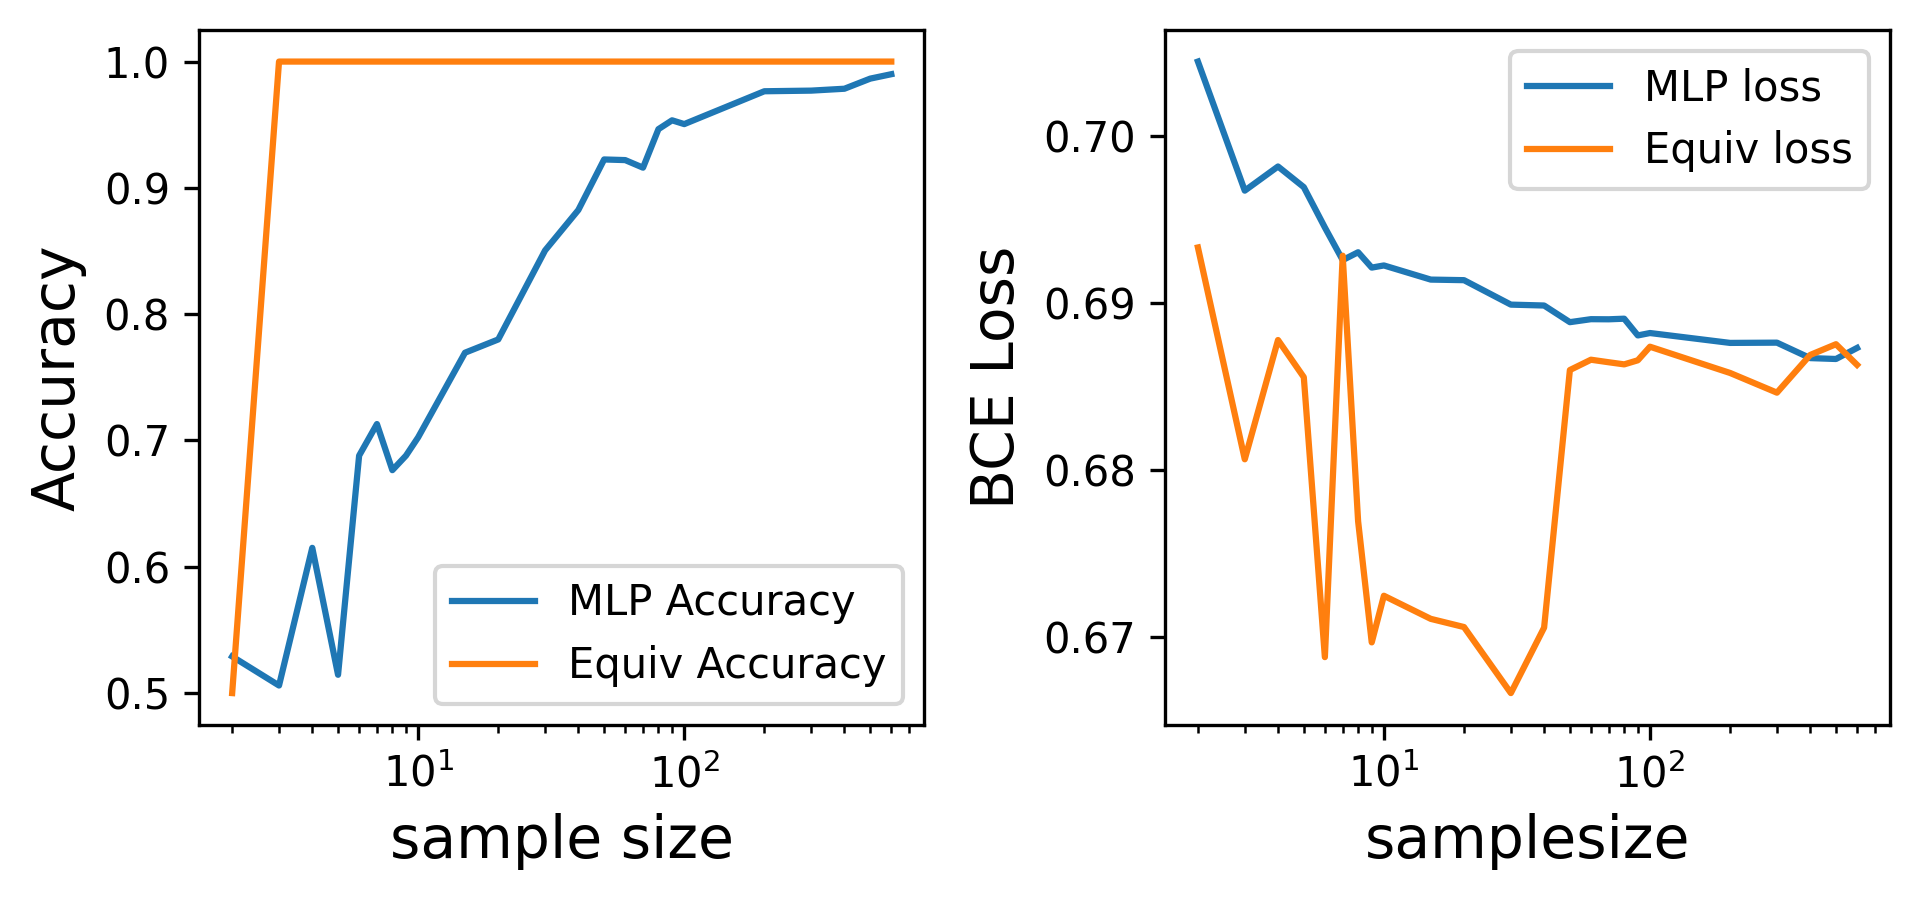

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6.5, 3.1), facecolor='white', dpi=300)
fig.add_subplot(1, 2, 1, frameon=True)

plt.plot(train_sample_sizes[:-5],mlp_accs[:-5],label='MLP Accuracy')
plt.plot(train_sample_sizes[:-5],emlp_accs,label='Equiv Accuracy')
plt.xlabel("sample size", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.xscale('log')
plt.tight_layout()

fig.add_subplot(1, 2, 2, frameon=True)

plt.plot(train_sample_sizes[:-5],mlp_losses[:-5],label='MLP loss')
plt.plot(train_sample_sizes[:-5],emlp_losses,label='Equiv loss')
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("samplesize", fontsize=14)
plt.ylabel("BCE Loss", fontsize=14)
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

plt.savefig('emlp_vs_mlp.png')
plt.savefig('emlp_vs_mlp.pdf')

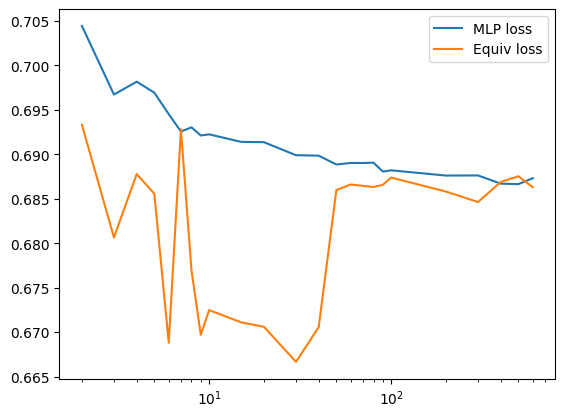

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_sample_sizes[:-5],mlp_losses[:-5],label='MLP loss')
plt.plot(train_sample_sizes[:-5],emlp_losses,label='Equiv loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')


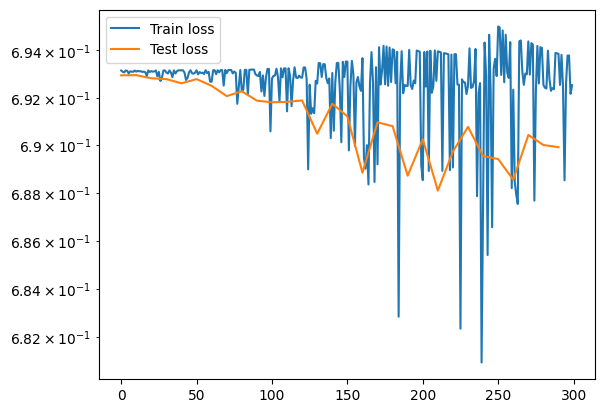

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [ ]:
test_logit = model(data['test_x'])

In [ ]:
pred = (model(x) > 0).astype(jnp.int16).flatten()

In [ ]:
pred.shape

(400,)

In [ ]:
data['test_y'].shape

(400,)

In [ ]:
acc = ((model(x) > 0).astype(jnp.int16).flatten() == y).mean()

In [ ]:
acc

Array(1., dtype=float32)



```
# This is formatted as code
```

## Poisson Bracket Training Loop

We build our EMLP model with [objax](https://objax.readthedocs.io/en/latest/) because we feel the object oriented design makes building complicated layers easier. Below is a minimal training loop that you could use to train EMLP.

In [ ]:
model = EMLP(Vector + T(2),Vector(G),group=G,num_layers=4,ch=100)
#model = MLP(Vector + T(2),Vector,group=G,num_layers=4,ch=50)


In [ ]:
BS=30
lr=1e-1
NUM_EPOCHS=200

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


opt = objax.optimizer.Adam(model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    #return (((yhat-y))**2).mean()
    return ((yhat-y)**2).mean()
grad_and_val = objax.GradValues(loss, model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [ ]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch%10:
        test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))

  0%|          | 0/200 [00:00<?, ?it/s]

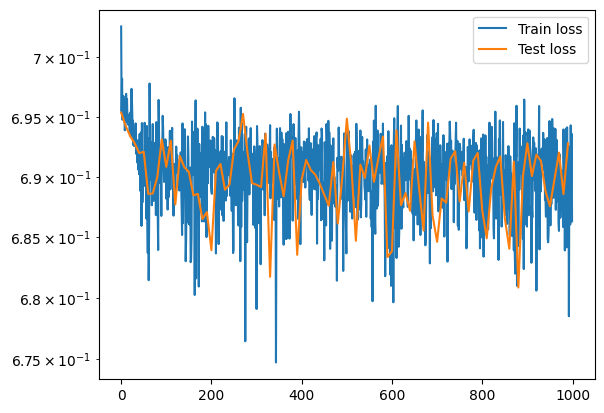

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [ ]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        #x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        #t2 = np.einsum('ni,nj->nij', np_x, np_x).reshape(-1, 4)
        #r = jnp.concat([x, t2], axis=1)
        #X = np.concatenate([np_x, t2], axis=1)

        dx = np.asarray(model(jnp.array([np_x]))).reshape(-1)
        #dx = np.asarray(model(x)).reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [ ]:
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(model, t_span, y0, **kwargs)

Text(0.5, 1.0, 'Baseline NN')

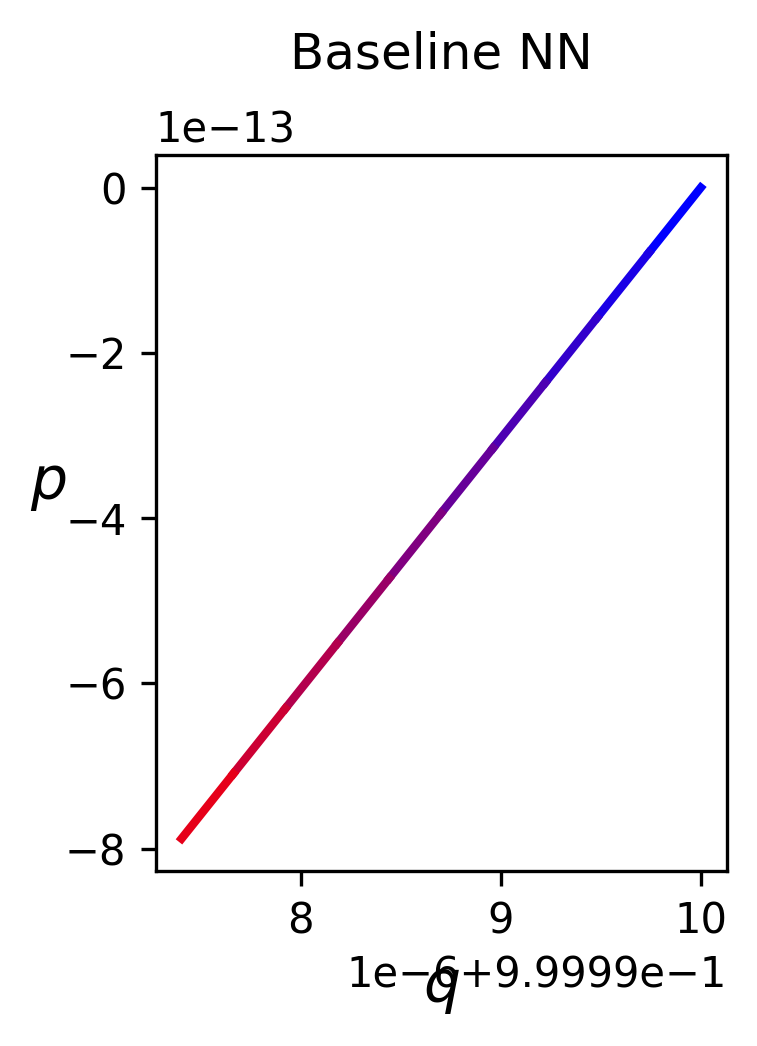

In [ ]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)


fig.add_subplot(1, 4, 3, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        #cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

In [ ]:
from jax import vmap
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

rin,rout = trainset.rep_in(G),trainset.rep_out(G)

def equivariance_err(mb):
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

As expected, the network continues to be equivariant as it is trained.

In [ ]:
print(f"Average test equivariance error {np.mean([equivariance_err(mb) for mb in testloader]):.2e}")

Average test equivariance error 4.34e-07


## Breaking EMLP down into equivariant layers (mid level)

Internally for EMLP, we use representations that [uniformly allocate dimensions](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.uniform_rep) between different tensor representations.

In [ ]:
from emlp.nn import uniform_rep
r = uniform_rep(512,G)
print(r)

80V⁰+20V+20V*+5V*²+10V⊗V*+5V²+4V²⊗V*+4V⊗V*²+V*³+V³+2V*⁴+V⁴+V²⊗V*²+V⁴⊗V*+V³⊗V*²+V⁵⊗V*


Below is a trimmed down version of EMLP, so you can see how it is built from the component layers `Linear`, `BiLinear`, and `GatedNonlinearities`. These layers can be constructed like ordinary objax modules, using the input and output representations.

In [ ]:
from objax.module import Module

class EMLPBlock(Module):
    """ Basic building block of EMLP consisting of G-Linear, biLinear,
        and gated nonlinearity. """
    def __init__(self,rep_in,rep_out):
        super().__init__()
        rep_out_wgates = emlp.nn.gated(rep_out)
        self.linear = emlp.nn.Linear(rep_in,rep_out_wgates)
        self.bilinear = emlp.nn.BiLinear(rep_out_wgates,rep_out_wgates)
        self.nonlinearity = emlp.nn.GatedNonlinearity(rep_out)
    def __call__(self,x):
        lin = self.linear(x)
        preact =self.bilinear(lin)+lin
        return self.nonlinearity(preact)

class EMLP(Module):
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        reps = [rep_in(group)]+num_layers*[uniform_rep(ch,group)]
        self.network = emlp.nn.Sequential(
            *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
            emlp.nn.Linear(reps[-1],rep_out(group))
        )
    def __call__(self,x,training=True):
        return self.network(x)

The representations of the hidden layers (taking place of the number of channels in a standard MLP) is by default given by this `uniform_rep` shown above. Unlike this pedagogical implementation you can specify the representation of the hidden layers directly in the [full EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.nn.html#emlp.nn.EMLP) by feeding in a representation to the `ch` argument, or even a list of representations to specify each hidden layer.

Note that since we are using the `GatedNonlinearity`, additional scalar gate channels need to be added to the output representation for the layer directly before the nonlinearity (in this case the `Linear` layer) which can be achieved with the `gated` function.

## The equivariant linear layers (low level)

At a lower level, the implementation of the `Linear` is fairly straightforward. An unconstrained bias `b` and weight matrix `w` are initialized. The projection matrices $P_b$ and $P_w$ are computed which are used project onto the symmetric subspace for each. Finally, during the forward pass, the unconstrained parameters are reshaped to vectors, projected via the matrices, and reshaped back to the original sizes. Then these projected parameters are applied to the input like a standard linear layer.

In [ ]:
from objax.variable import TrainVar
from objax.nn.init import orthogonal

class Linear(Module):
    """ Basic equivariant Linear layer from repin to repout."""
    def __init__(self, repin, repout):
        nin,nout = repin.size(),repout.size()
        self.b = TrainVar(objax.random.uniform((nout,))/jnp.sqrt(nout))
        self.w = TrainVar(orthogonal((nout, nin)))
        self.rep_W = rep_W = repout*repin.T

        self.Pb = repout.equivariant_projector() # the bias vector has representation repout
        self.Pw = rep_W.equivariant_projector()

    def __call__(self, x):
        W = (self.Pw@self.w.value.reshape(-1)).reshape(*self.w.value.shape)
        b = self.Pb@self.b.value
        return x@W.T+b